In [2]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
import urllib.request
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
destination = 'input.txt'
urllib.request.urlretrieve(url, destination)

('input.txt', <http.client.HTTPMessage at 0x1ea93480a30>)

In [3]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))
print(f"Sample of first 3 characters: `{text[:3]}`")
print(f"Sample of first 1000 characers: \n `{text[:1000]}`")

length of dataset in characters:  1115394
Sample of first 3 characters: `Fir`
Sample of first 1000 characers: 
 `First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with

In [4]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text))) #Set> No duplicates, list> oredenable, sorted> order
vocab_size = len(chars)
print("Distinct possible characters:",''.join(chars))
print("Vocabulary size:",vocab_size)

Distinct possible characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocabulary size: 65


In [5]:
# Tokenization of the text:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
#print(stoi)
itos = { i:ch for i,ch in enumerate(chars) }
#print(itos)
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [6]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print("Tneosr shape and data type:",data.shape, data.dtype)
print("First 10 character encoded:",data[:10]) 

Tneosr shape and data type: torch.Size([1115394]) torch.int64
First 10 character encoded: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])


In [7]:
#Test train split
from sklearn.model_selection import train_test_split
train_data,val_data = train_test_split(data,test_size=0.1,random_state=12312)

In [8]:
#Block size is basically the context lenght. A block size of 8 has multiple examples packed into it!
block_size = 8
train_data[:block_size+1]

tensor([ 1,  5, 52, 43,  0, 58,  1, 47, 42])

In [10]:
#This is how this stuff works. Basically, given the previous encoded characters as input, it must predict the target character that follows itself.
#A block size of 8 means that it will got 8 example to predict, so when training it, we will make it so that it will make predictions on ALL 8 positions simultaneously.
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([1]) the target: 5
when input is tensor([1, 5]) the target: 52
when input is tensor([ 1,  5, 52]) the target: 43
when input is tensor([ 1,  5, 52, 43]) the target: 0
when input is tensor([ 1,  5, 52, 43,  0]) the target: 58
when input is tensor([ 1,  5, 52, 43,  0, 58]) the target: 1
when input is tensor([ 1,  5, 52, 43,  0, 58,  1]) the target: 47
when input is tensor([ 1,  5, 52, 43,  0, 58,  1, 47]) the target: 42


In [13]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) #Pick batch_size random numbers between the training data numbers with index len(data) - enoguh so as to have 1 full set of examples. Output: 4 random integers.
    x = torch.stack([data[i:i+block_size] for i in ix])  # The first block size characters starting at i, till you get 8 consecutives. This repeted i times. In this case,
    #we got a 4*8 matrix output.
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # Offset by 1 x, this will be our targets.
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")
print("")

tensor([ 76049, 234249, 934904, 560986])
inputs:
torch.Size([4, 8])
tensor([[53, 42, 32, 15, 41, 53,  1,  1],
        [43,  1, 49, 56, 63,  0, 41, 56],
        [ 1, 58, 45, 47, 52, 42,  1, 47],
        [59,  1, 57,  1, 43, 60, 42, 59]])
targets:
torch.Size([4, 8])
tensor([[42, 32, 15, 41, 53,  1,  1, 41],
        [ 1, 49, 56, 63,  0, 41, 56, 51],
        [58, 45, 47, 52, 42,  1, 47, 43],
        [ 1, 57,  1, 43, 60, 42, 59,  0]])
----
when input is [53] the target: 42
when input is [53, 42] the target: 32
when input is [53, 42, 32] the target: 15
when input is [53, 42, 32, 15] the target: 41
when input is [53, 42, 32, 15, 41] the target: 53
when input is [53, 42, 32, 15, 41, 53] the target: 1
when input is [53, 42, 32, 15, 41, 53, 1] the target: 1
when input is [53, 42, 32, 15, 41, 53, 1, 1] the target: 41
when input is [43] the target: 1
when input is [43, 1] the target: 49
when input is [43, 1, 49] the target: 56
when input is [43, 1, 49, 56] the target: 63
when input is [43, 1, 49, 

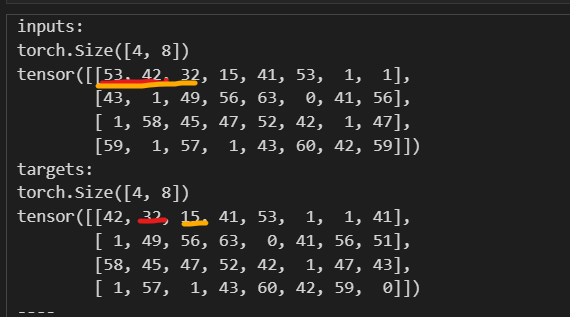

In [27]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


torch.Size([32, 65])
tensor(4.7516, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3
